# Importing a GPX file
## And iterpolating some data!
A major point of interpolation is that it can be used with actual data. A GPX file, for example, stores geographic data that can be gathered using a GPS.  Here's an example.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In addtion to the standard imports above, we'll need a tool to parse XML and a utiliy to deal with time stamps in the file.

In [2]:
import xml.etree.ElementTree as ET
from datetime import datetime

In this next bit, we read in the GPX file and process it to store the information is easily accessed Python lists.

In [3]:
tree = ET.parse('AOTC.gpx')
root = tree.getroot()
trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
trkpts = []
for trkseg in trksegs:
    trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
elevations = []
times = []
start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%S.000Z')
for trkpt in trkpts:
    time = trkpt.find('{http://www.topografix.com/GPX/1/1}time')
    time = datetime.strptime(time.text, '%Y-%m-%dT%H:%M:%S.000Z')
    times.append((time-start_time).seconds)
    elevation = float(trkpt.find('{http://www.topografix.com/GPX/1/1}ele').text)
    elevations.append(elevation)
stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
lon_pts = lon_pts[:stop_idx]
lat_pts = lat_pts[:stop_idx]
elevations = elevations[:stop_idx]
times = times[:stop_idx]
duration = times[-1]/60**2

Let's see what these `lat_pts` and `lon_pts` look like.

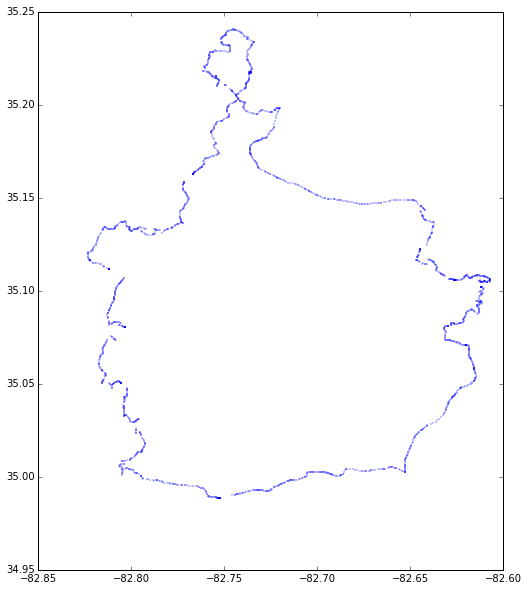

In [4]:
plt.plot(lon_pts,lat_pts, '.', markersize=1)
ax = plt.gca()
ax.set_aspect(1)
fig = plt.gcf()
fig.set_size_inches(10,10)

This might be easier to comprehend on a an [actual map](http://www.marksmath.org/maps/AOTC.html).

If we know a little spherical geometry, we can process these lat/lon points into a distances array to keep track of accumulated distances. We can plot this versus the elevations to obtain an elevation profile.

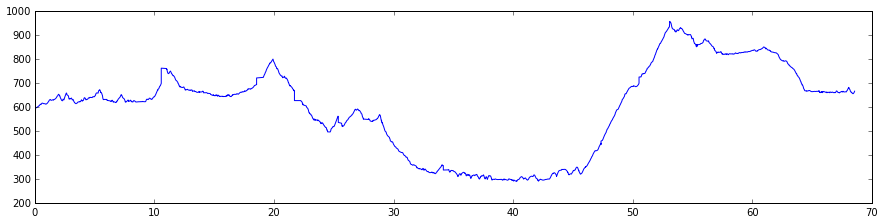

In [5]:
pio180 = np.pi/180
def dist(lat1,lon1, lat2,lon2): 
    return 7920*np.arcsin(np.sqrt(np.sin(pio180*(lat1-lat2)/2)**2 + \
        np.cos(pio180*lat1)*np.cos(pio180*lat2)*np.sin(pio180*(lon1-lon2)/2)**2))
distances = [0]
for i in range(len(lat_pts)-1):
    step = dist(lat_pts[i],lon_pts[i], lat_pts[i+1],lon_pts[i+1])
    distances.append(distances[i] + step)
plt.plot(distances,elevations)
ax = plt.gca()
ax.set_aspect(1/50)
fig = plt.gcf()
fig.set_size_inches(15,15)

The whole thing was $68.5$ miles in about $4$ hours and $40$ minutes, including a nice rest at the top of Ceasar's head.

In [6]:
[distances[-1],times[-1]/60**2]

[68.560628152389981, 4.645833333333333]

Now, suppose we want to know how long it took to ride the first $50$ miles.  We could probably guesstimate with the list of distances as compared to the list of times. If we distance travelled expressed as a *function* of time, though, then we could solve the equation $\text{dist}(t)=50$. That's exactly where interpolation comes in!

In [7]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d
dist_func = interp1d(times, distances)
brentq(lambda t: dist_func(t)-50, 0, times[-1])/60**2

3.1612277275917515